<a href="https://colab.research.google.com/github/Vaipik/GoIT-PyDS7/blob/main/tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [1]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 2000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Создадим нейронную сеть
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name='w'
            )
        self.b = tf.Variable(tf.zeros([out_features]), name='b')
    
    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Выходной слой
    # Место для вашего кода
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Место для вашего кода
    # ...

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов
    x = self.layer_1(x)
    x = self.layer_2(x)
    x = self.out_layer(x)
    return tf.nn.softmax(x)
    

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    _accuracy = tf.metrics.Accuracy()
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    _accuracy.update_state(y_true, y_pred_labels)
    
    return _accuracy.result()


In [7]:

# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    params = nn.trainable_variables
    # Вычислим по ним значение градиента
    # Место для вашего кода
    gradients = g.gradient(loss, params)
    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(gradients, params))

In [8]:


# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (x_batch, y_batch) in enumerate(train_data.take(training_steps)):
    # Место для вашего кода
    train(neural_net, x_batch, y_batch)
    
    if step % display_step == 0:
        pred = neural_net(x_batch)
    
        loss = cross_entropy(pred, y_batch)
        loss_history.append(loss)
        
        _accuracy = accuracy(pred, y_batch)
        accuracy_history.append(_accuracy)
        
        print(f'Step: {step} | Loss: {loss:.2f} | Accuracy: {_accuracy:.2f}')



Step: 0 | Loss: 599.47 | Accuracy: 0.09
Step: 100 | Loss: 566.41 | Accuracy: 0.20
Step: 200 | Loss: 549.54 | Accuracy: 0.32
Step: 300 | Loss: 528.17 | Accuracy: 0.36
Step: 400 | Loss: 519.71 | Accuracy: 0.43
Step: 500 | Loss: 512.18 | Accuracy: 0.43
Step: 600 | Loss: 497.88 | Accuracy: 0.51
Step: 700 | Loss: 503.02 | Accuracy: 0.50
Step: 800 | Loss: 480.17 | Accuracy: 0.56
Step: 900 | Loss: 495.81 | Accuracy: 0.50
Step: 1000 | Loss: 473.85 | Accuracy: 0.59
Step: 1100 | Loss: 483.47 | Accuracy: 0.57
Step: 1200 | Loss: 465.58 | Accuracy: 0.65
Step: 1300 | Loss: 478.23 | Accuracy: 0.57
Step: 1400 | Loss: 468.90 | Accuracy: 0.61
Step: 1500 | Loss: 461.72 | Accuracy: 0.62
Step: 1600 | Loss: 463.47 | Accuracy: 0.64
Step: 1700 | Loss: 457.83 | Accuracy: 0.66
Step: 1800 | Loss: 467.51 | Accuracy: 0.63
Step: 1900 | Loss: 474.09 | Accuracy: 0.59


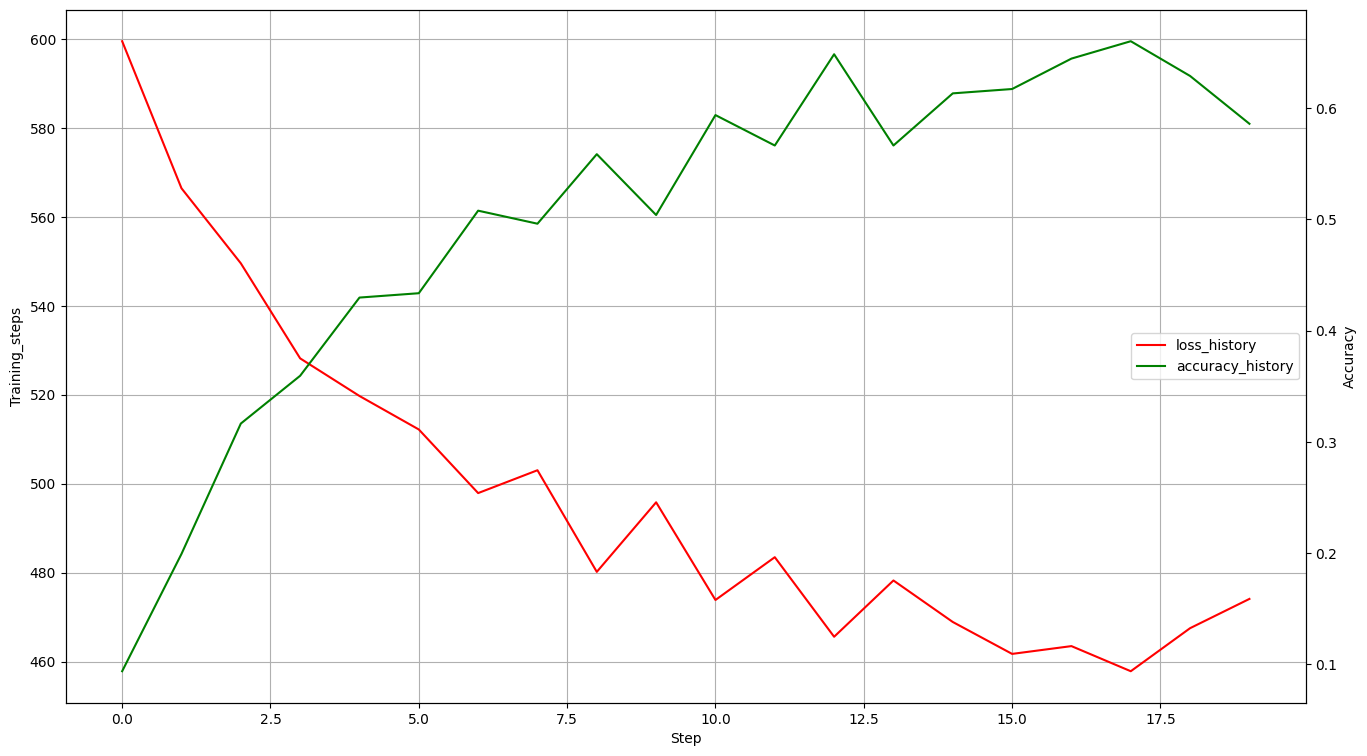

In [10]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 9))
plt.grid()


ax1.plot(loss_history, label='loss_history', color='red')
ax1.set_xlabel('Step')
ax1.set_ylabel('Training_steps')

ax2 = ax1.twinx()
ax2.plot(accuracy_history, label='accuracy_history', color='green')
ax2.set_xlabel('Step')
ax2.set_ylabel('Accuracy')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right');

In [11]:
# Вычислите точность обученной нейросети

# Место для вашего кода
nn_accuracy = accuracy(neural_net(x_test), y_test)
print(f"Accuracy: {nn_accuracy:.2f}")

Accuracy: 0.64


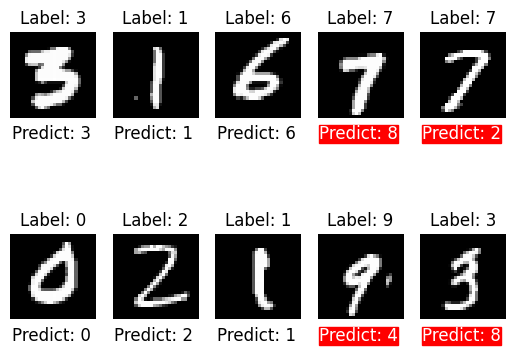

In [14]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода

test_data = np.random.choice(range(len(x_test)), size=10, replace=False)
test_images = x_test[test_data]
test_labels = y_test[test_data]

pred_data = [np.argmax(neural_net(np.array([x]))) for x in test_images]

for i, idx in enumerate(test_data):
    img = test_images[i]
    label = test_labels[i]

    img = img.reshape((28, 28))

    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    
    pred_label = pred_data[i]
    if pred_label != label:
        plt.text(0, 30, f"Predict: {pred_label}", color='white', fontsize=12, ha='left', va='top',
                 bbox=dict(facecolor='red', edgecolor='red', pad=0))
    else:
        plt.text(0, 30, f"Predict: {pred_label}", color='black', fontsize=12, ha='left', va='top')

plt.show()